In [1]:
"""Detector Benchmark File

This script is used to benchmark detector performance.
"""

import cv2
import numpy as np
import torch
import sys
sys.path.append('ScaledYOLOv4/')
from ScaledYOLOv4.utils.general import bbox_iou
import glob
from copy import deepcopy
from chrono import Timer

from detection import houghDetect, templateMatch, hsvDetect
from YOLO_detector_wrapper import setup, detect_wrapper
from functools import partial

import os
import math

output_root_directory = r"../Data_Generator/Data_Generator_Outputs/"

image_count_variants = [os.path.join(output_root_directory, dir_item, "test", "images")+"/" for dir_item in os.listdir(output_root_directory)]
label_count_variants = [os.path.join(output_root_directory, dir_item, "test", "labels")+"/" for dir_item in os.listdir(output_root_directory)]

"""#Test on only 5s
image_count_variants = [[os.path.join(output_root_directory, dir_item, "test", "images")+"/" for dir_item in os.listdir(output_root_directory)][-3]]
label_count_variants = [[os.path.join(output_root_directory, dir_item, "test", "labels")+"/" for dir_item in os.listdir(output_root_directory)][-3]]"""

# Define detector(s)
hough = partial(houghDetect, dp = 1.5, minDist = 20, 
                        param1 = 27, param2 = 19, 
                        minRadius = 12, maxRadius = 15, debug = False)

hsv = partial(hsvDetect, hue_low = 0, hue_high = 179, 
                    sat_low = 0, sat_high = 94, 
                    val_low = 56, val_high = 255, debug = False)

template0 = partial(templateMatch, match_threshold = 30, template_path_idx = 0)
template1 = partial(templateMatch, match_threshold = 50, template_path_idx = 1)
model = setup()
yolo = partial(detect_wrapper, model=model, debug=False)


# Initialise list for detectors
detector_funcs = [hough, hsv, template0, template1, yolo]

comparison_times = []
comparison_accs = []
for image_paths, label_paths in zip(image_count_variants, label_count_variants):
    print(image_paths)

    # Paths for test images and labels
    image_paths = image_paths+"/"
    label_paths = label_paths+"/"

    # Find all items at target path
    images = sorted(glob.glob(image_paths + "*.jpg"))
    labels = sorted(glob.glob(label_paths + "*.txt"))

    # Initialise lists for AP scores, and detection times
    detector_aps = []
    detection_times = []

    # Set the IoU threshold for TP detection
    #iou_thresh = 0.4
    iou_thresh = 0.1

    # Iterate through detection functions
    for detector_func in detector_funcs:

        # Initialise variables
        gt_bboxes = []
        total_positives = 0
        _detection_times = []

        # "detections" is list of dictionaries to encode detections
        #Image = image index, Bbox = bbox coordinates, Conf = confidence
        #TP/FP = binary flag indicating TP (1) or FP (0)
        #detections = [{"image":[]}, {"bbox":[]}, {"conf":[]}, {"TP/FP":[]}]
        detections = []

        # Iterate through all images and labels for detections
        for index, (img_path, label_path) in enumerate(zip(images, labels)):
            # print(index)
            # Read image and resize to 50%
            img = cv2.imread(img_path)
            img = cv2.resize(img, (int(img.shape[1] * 0.5), int(img.shape[0] * 0.5)))

            gt_bboxes.append([])

            # Read contents of GT label data
            with open(label_path) as file:
                bboxes = file.readlines()
                for bbox in bboxes:
                    # Read data and split into separate variables
                    obj_class, x, y, w, h = list(map(float, bbox.rstrip().split(" ")))

                    # Undo normalisation of bbox
                    x, w = int(x * img.shape[1]), int(w * img.shape[1])
                    y, h = int(y * img.shape[0]), int(h * img.shape[0])

                    # Convert bbox notation to corner points
                    x1, x2 = int(x - w/2), int(x + w/2)
                    y1, y2 = int(y - h/2), int(y + h/2)
                    gt_bboxes[index].append((x1,y1,x2,y2))
                    
            
            # Increment total number of GT detections => this is TP + FN
            total_positives += len(gt_bboxes[index])

            # Perform detection, and log detection time
            with Timer() as timed:
                ret, bboxes, points = detector_func(img)
            _detection_times.append(timed.elapsed)
            
            # Iterate through frames and store information in "detections" list
            for bbox in bboxes:
                x1, y1, x2, y2, conf, class_id = bbox
                _image = index
                _bbox = (x1,y1,x2,y2)
                _conf = conf
                
                #Check bbox size => small hsv causing large error... (not an issue for centroid)
                #print(x2-x1, y2-y1, 30, 30)

                # Iterate through all gt_bboxes, calculating IoU to identify if TP/FP
                flag = True
                for gt_bbox in gt_bboxes[index]:
                    iou = bbox_iou(torch.FloatTensor(bbox[:4]), torch.FloatTensor(gt_bbox))

                    # If IoU exceeds threshold, then true positive
                    if iou > iou_thresh:
                        detections.append({"image":_image, "bbox":_bbox, "conf":_conf, "TP/FP":1})
                        flag = False
                        break
                
                # Flag remaining active indicated false positive
                if flag:
                    detections.append({"image":_image, "bbox":_bbox, "conf":_conf, "TP/FP":0})

        # Then sort the detections by decreasing confidence
        sorted_detections = sorted(detections, key=lambda x: x["conf"], reverse=True)

        # Iterate through detections to find the accumulated metrics
        for index, det in enumerate(sorted_detections):

            # If first entry, assign accumulators as current TP/FP status
            if index == 0:
                det["Acc_TP"] = 1 if det["TP/FP"] else 0
                det["Acc_FP"] = 0 if det["TP/FP"] else 1
            
            # Otherwise, find current TP/FP status, and add to previous accumulator states
            else:
                delta_accTP = 1 if det["TP/FP"] else 0
                delta_accFP = 0 if det["TP/FP"] else 1
                det["Acc_TP"] = sorted_detections[index-1]["Acc_TP"] + delta_accTP
                det["Acc_FP"] = sorted_detections[index-1]["Acc_FP"] + delta_accFP

            # Calculate the precision (TP/(TP+FP)) and recall (TP/(TP+FN))
            TP, FP = det["Acc_TP"], det["Acc_FP"]
            precision = TP / (TP + FP)
            recall = TP / total_positives
            det["Precision"] = precision
            det["Recall"] = recall

        # Find the 11-pt interpolated Average Precision (AP)
        precisions = np.asarray([d["Precision"] for d in sorted_detections])
        recalls = np.asarray([d["Recall"] for d in sorted_detections])
        ap_interpolate = 1/11 * sum([max(precisions[recalls>n/10]) \
                 for n in range(0,math.ceil(max(recalls)*10))])
        #print("Interpolated AP:", ap_interpolate)
        
        # Append detector metrics to list
        detection_times.append(np.mean(_detection_times))
        detector_aps.append(ap_interpolate)

    # Print out metrics
    #print("Detectors: Hough, HSV, Template (Raw), Template (Averaged), YOLO")
    #print("Detection Time(s):", detection_times)
    #print("Detection AP(s):", detector_aps)

    # Append data to lists for logging across different detector counts
    comparison_times.append(detection_times)
    comparison_accs.append(detector_aps)


# Group data by detector
grouped_times = [[item[i]*1000 for item in comparison_times] for i in range(len(comparison_times[0]))]
grouped_accs = [[item[i] for item in comparison_accs] for i in range(len(comparison_accs[0]))]


Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Fusing layers... Model Summary: 235 layers, 5.24706e+07 parameters, 5.04494e+07 gradients
../Data_Generator/Data_Generator_Outputs/50/test/images/
Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaD

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memor

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memory=11175MB)

Using CUDA device0 _CudaDeviceProperties(name='GeForce GTX 1080 Ti', total_memor

In [37]:
# Save out the data
import pandas as pd
from copy import deepcopy
detector_labels = ["No. of Objects (times, accuracies) / Technique", "Hough", "HSV", "Template (Raw)", "Template (Averaged)", "Scaled-YOLOv4"]
#times, accuracies
rows = [5, 50, 500, 5, 50, 500]

_grouped_times = deepcopy(grouped_times)
_grouped_accs = deepcopy(grouped_accs)

for i in range(len(_grouped_times)):
    # Reorder the metrics to satisfy increasing detector counts (hard coded, but could do programatically)
    _grouped_times[i] = [_grouped_times[i][2], _grouped_times[i][0], _grouped_times[i][1]]
    _grouped_accs[i] = [_grouped_accs[i][2], _grouped_accs[i][0], _grouped_accs[i][1]]

a = np.asarray(rows)
b = np.asarray([np.asarray(_grouped_times).T, np.asarray(_grouped_accs).T])
b = b.reshape(len(rows),-1)

df = pd.DataFrame(np.vstack((a.T,b.T)).T, columns = detector_labels)
df.to_csv("Detector_Benchmark_Data.csv", index=False)


In [ ]:
"""
# Set up plots
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

# For pgf output for Latex
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


#plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'font.size': 16})

fig = plt.figure()
ax = fig.add_subplot(111)

# Plot the performance data
detector_labels = ["Hough", "HSV", "Template (Raw)", "Template (Averaged)", "Scaled-YOLOv4"]
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(detector_labels)]
for i in range(len(grouped_times)):
    # Reorder the metrics to satisfy increasing detector counts (hard coded, but could do programatically)
    grouped_times[i] = [grouped_times[i][2], grouped_times[i][0], grouped_times[i][1]]
    grouped_accs[i] = [grouped_accs[i][2], grouped_accs[i][0], grouped_accs[i][1]]

    # Plot the line
    ax.plot(grouped_times[i], grouped_accs[i], label=detector_labels[i], color = colors[i])
    
    # Draw markers for each point
    markers = ["o", "s", "v"]
    for j in range(0, len(grouped_times[i])):
        ax.plot(grouped_times[i][j], grouped_accs[i][j], markers[j], color = colors[i], fillstyle="none")

# Plot the 30FPS line
import matplotlib.transforms as transforms
ax.axvline(x=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(33.3 - ax.get_xlim()[1] * 0.1 - 2, 0.02), \
            xycoords="data", color="black")

# Set axes labels
ax.set_xlabel("Detection Speed (ms/image)")
ax.set_ylabel("Test AP")

# Add markers to legend
handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
legend_additions = [Line2D([0], [0], marker='o', color='w', label='5 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"),
         Line2D([0], [0], marker='s', color='w', label='50 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"), 
         Line2D([0], [0], marker='v', color='w', label='500 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none")]
handles.extend(legend_additions) 
ax.legend(handles=handles, loc="lower right")

# Resize and show plot
ax.set_ylim([0, 1])
ax.set_xlim([0, 80])
plt.tight_layout()

plt.savefig('Detector_Benchmark.pgf')
#plt.show()
"""

In [39]:
import pandas as pd
df_in = pd.read_csv("Detector_Benchmark_Data.csv")
df_in

,"No. of Objects (times, accuracies) / Technique",Hough,HSV,Template (Raw),Template (Averaged),Scaled-YOLOv4
0,5.0,2.578743,7.828648,33.315451,33.339388,21.558588
1,50.0,3.977935,8.786702,35.061948,35.953323,22.814103
2,500.0,11.509073,13.590485,51.927900,67.927510,32.037258
3,5.0,0.754165,0.859029,0.909091,0.837085,0.909091
4,50.0,0.620680,0.837367,0.818182,0.743369,0.909091
5,500.0,0.792269,0.815270,0.818182,0.882502,0.909091


In [44]:
labels = df_in.columns.values[1:]
labels

array(['Hough', 'HSV', 'Template (Raw)', 'Template (Averaged)', 'Scaled-YOLOv4'], dtype=object)

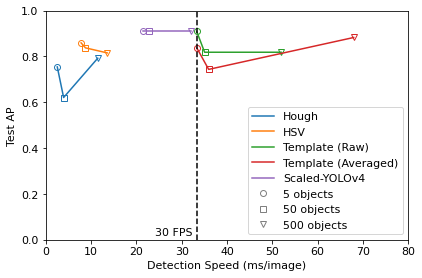

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)

#for i in range(0,len(df_in),2):
    #ax.plot(grouped_times[i], grouped_accs[i], label=detector_labels[i], color = colors[i])
    #print(i)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(labels)]
for index, label in enumerate(labels):
    ax.plot(df_in[label].values[:len(df_in)//2],df_in[label].values[len(df_in)//2:], label=label, color = colors[index])
    
    markers = ["o", "s", "v"]
    for j in range(0, len(df_in)//2):
        ax.plot(df_in[label].values[:len(df_in)//2][j], df_in[label].values[len(df_in)//2:][j], markers[j], color = colors[index], fillstyle="none")
    
    # Plot the 30FPS line
import matplotlib.transforms as transforms
ax.axvline(x=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(33.3 - ax.get_xlim()[1] * 0.1 - 2, 0.02), \
            xycoords="data", color="black")

# Set axes labels
ax.set_xlabel("Detection Speed (ms/image)")
ax.set_ylabel("Test AP")

# Add markers to legend
handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
legend_additions = [Line2D([0], [0], marker='o', color='w', label='5 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"),
         Line2D([0], [0], marker='s', color='w', label='50 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"), 
         Line2D([0], [0], marker='v', color='w', label='500 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none")]
handles.extend(legend_additions) 
ax.legend(handles=handles, loc="lower right")

# Resize and show plot
ax.set_ylim([0, 1])
ax.set_xlim([0, 80])
plt.tight_layout()

plt.show()

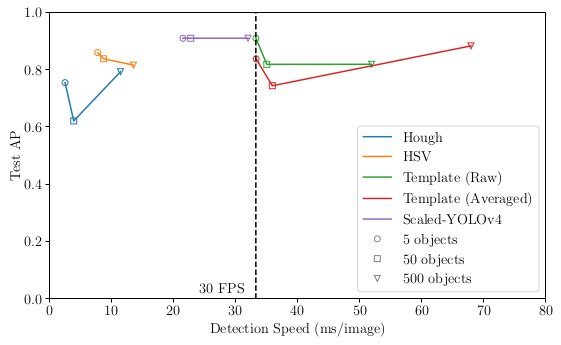

In [66]:
# Set up plots
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms

# For pgf output for Latex
import matplotlib

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})


#plt.rcParams.update({'font.size': 13})
plt.rcParams.update({'font.size': 14})
#fig = plt.figure(figsize=(7, 5))
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(labels)]
for index, label in enumerate(labels):
    ax.plot(df_in[label].values[:len(df_in)//2],df_in[label].values[len(df_in)//2:], label=label, color = colors[index])
    
    markers = ["o", "s", "v"]
    for j in range(0, len(df_in)//2):
        ax.plot(df_in[label].values[:len(df_in)//2][j], df_in[label].values[len(df_in)//2:][j], markers[j], color = colors[index], fillstyle="none")
    
    # Plot the 30FPS line
import matplotlib.transforms as transforms
ax.axvline(x=33.3, color='black', linestyle='--')
ax.annotate(text="30 FPS", xy =(33.3 - ax.get_xlim()[1] * 0.1 - 2, 0.02), \
            xycoords="data", color="black")

# Set axes labels
ax.set_xlabel("Detection Speed (ms/image)")
ax.set_ylabel("Test AP")

# Add markers to legend
handles, labels = ax.get_legend_handles_labels()
from matplotlib.lines import Line2D
legend_additions = [Line2D([0], [0], marker='o', color='w', label='5 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"),
         Line2D([0], [0], marker='s', color='w', label='50 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none"), 
         Line2D([0], [0], marker='v', color='w', label='500 objects',
                          markeredgecolor='gray', markersize=6, fillstyle="none")]
handles.extend(legend_additions) 
ax.legend(handles=handles, loc="lower right")

# Resize and show plot
ax.set_ylim([0, 1])
ax.set_xlim([0, 80])
plt.tight_layout()

#plt.show()
plt.savefig('Detector_Benchmark.pgf')